In [1]:
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

from mpl_toolkits.basemap import Basemap
from sklearn.cluster import DBSCAN

%matplotlib inline

## Data

In [2]:
DATA_DIR = "data"

In [3]:
headlines_df = pd.read_csv(os.path.join(DATA_DIR, "headlines-with-latlon.csv"))
headlines_df.head()

,headline,city,countrycode,latitude,longitude
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667


## United States only

In [4]:
usa_headlines_df = headlines_df[headlines_df["countrycode"]=="US"]
usa_headlines_df.head()

,headline,city,countrycode,latitude,longitude
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667
6,Zika Concerns are Spreading in Houston,Houston,US,29.76328,-95.36327


In [5]:
map_plotter = Basemap()

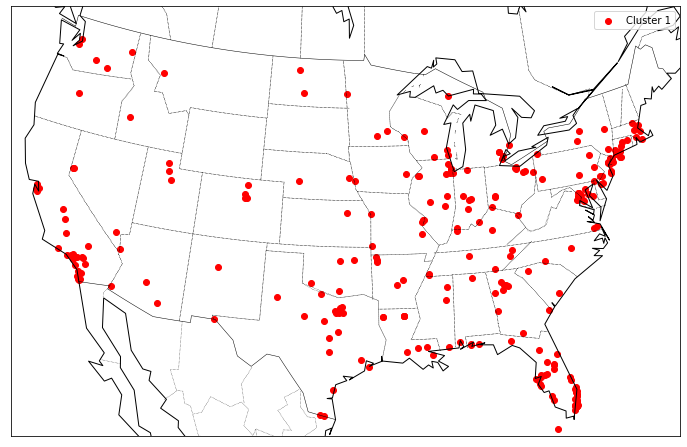

In [6]:
def scatterplot_us(map_plotter, coordinates_list, colors):
    assert(len(coordinates_list) == len(colors))
    fig = plt.figure(figsize=(12, 8))
    map_lcc = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119,
                      llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49, 
                      lat_1=33,lat_2=45)
    for cid, (coordinates, color) in enumerate(zip(coordinates_list, colors)):
        latitudes, longitudes = coordinates[:, 0], coordinates[:, 1]
        map_lcc.scatter(longitudes, latitudes, latlon=True, color=color,
                            label="Cluster {:d}".format(cid + 1))
    map_lcc.drawcoastlines()
    map_lcc.drawcountries()
    map_lcc.drawstates(linestyle="dotted")
    plt.legend(loc="best")
    _ = plt.show()


coordinates = usa_headlines_df[["latitude", "longitude"]].values
scatterplot_us(map_plotter, [coordinates], ["r"])

In [7]:
def great_circle_distance(x1, x2, radius=3956):
    x1 = np.radians(x1)
    x2 = np.radians(x2)
    
    if np.array_equal(x1, x2):
        return 0
    
    delta_x, delta_y = x1 - x2
    haversin = np.sin(delta_x / 2) ** 2 + (
        np.cos(x1[0]) * np.cos(x2[0]) * np.sin(delta_y / 2) ** 2)
    return 2 * radius * np.arcsin(haversin ** 0.5)


In [8]:
us_model = DBSCAN(min_samples=3, eps=100, metric=great_circle_distance)
cluster_ids = us_model.fit_predict(coordinates)

In [9]:
cids, ccounts = np.unique(cluster_ids, return_counts=True)
for cid, ccount in zip(cids, ccounts):
    print(cid, ccount)

-1 48
0 46
1 58
2 14
3 10
4 28
5 5
6 3
7 20
8 9
9 13
10 6
11 5
12 4
13 3
14 4
15 4


In [10]:
usa_headlines_df["cluster"] = cluster_ids
usa_headlines_df.head()

/Users/palsujit/anaconda3/envs/disease/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,headline,city,countrycode,latitude,longitude,cluster
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,0
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597,1
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,0
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667,2
6,Zika Concerns are Spreading in Houston,Houston,US,29.76328,-95.36327,-1


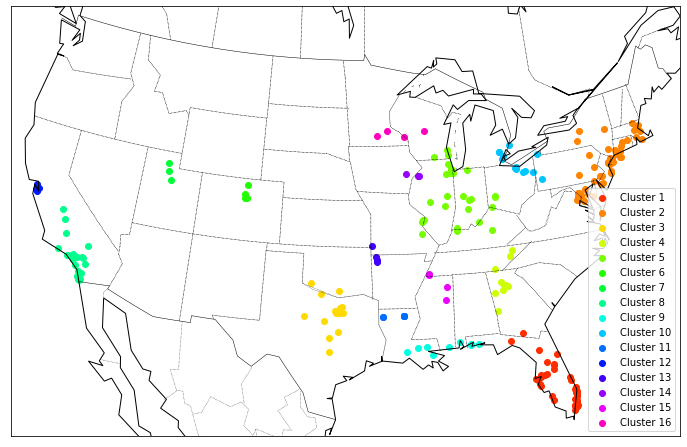

In [11]:
coordinates_list, colors = [], []

cluster_ids = np.unique(usa_headlines_df["cluster"].values)
color_ids = np.linspace(0, 1, len(cluster_ids))
cmap = mpl.cm.get_cmap("gist_rainbow")

for i in range(len(cluster_ids)):
    if cluster_ids[i] == -1:
        continue
    coordinates_list.append(
        usa_headlines_df[usa_headlines_df["cluster"]==cluster_ids[i]][["latitude", "longitude"]].values)
    colors.append(cmap(color_ids[i]))
    
scatterplot_us(map_plotter, coordinates_list, colors)

### Clusters sorted by number of headlines

In [12]:
usa_cluster_df = (usa_headlines_df[usa_headlines_df["cluster"] != -1]
                          .groupby("cluster")["headline"]
                          .count()
                          .reset_index(name="count")
                          .sort_values(["count"], ascending=False))
usa_cluster_df.head(len(coordinates_list))

,cluster,count
1,1,58
0,0,46
4,4,28
7,7,20
2,2,14
9,9,13
3,3,10
8,8,9
10,10,6
5,5,5


### Headlines sorted by proximity to cluster centroid

We will look at the headlines for the top 6 (`count > 10`) clusters. 

In [13]:
def compute_cluster_properties(row):
    d = {}
    d["num_headlines"] = row["headline"].count()
    d["centroid_lat"] = row["latitude"].mean()
    d["centroid_lon"] = row["longitude"].mean()
    return pd.Series(d, index=["num_headlines", "centroid_lat", "centroid_lon"])

usa_cluster_df = (usa_headlines_df[usa_headlines_df["cluster"] != -1]
                  .groupby("cluster")["headline", "latitude", "longitude"]
                  .apply(compute_cluster_properties)
                  .sort_values(["num_headlines"], ascending=False)
                  .reset_index("cluster"))
usa_cluster_df.head()

,cluster,num_headlines,centroid_lat,centroid_lon
0,1,58.0,40.514578,-74.635214
1,0,46.0,27.035336,-80.987287
2,4,28.0,40.097244,-87.480215
3,7,20.0,34.017128,-117.836087
4,2,14.0,32.689150,-97.713501


In [14]:
usa_headlines_scored_df = usa_headlines_df.merge(usa_cluster_df, on="cluster")
usa_headlines_scored_df.head()

,headline,city,countrycode,latitude,longitude,cluster,num_headlines,centroid_lat,centroid_lon
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,0,46.0,27.035336,-80.987287
1,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,0,46.0,27.035336,-80.987287
2,Brownsville teen contracts Zika virus,Brownsville,US,25.82176,-80.24116,0,46.0,27.035336,-80.987287
3,Orlando volunteers aid Zika research,Orlando,US,28.53834,-81.37924,0,46.0,27.035336,-80.987287
4,Tampa Bay Area Zika Case Count Climbs,Tampa,US,27.94752,-82.45843,0,46.0,27.035336,-80.987287


In [15]:
usa_headlines_scored_df["dist_from_centroid"] = usa_headlines_scored_df.apply(
    lambda row: great_circle_distance([row["latitude"], row["longitude"]], 
                                      [row["centroid_lat"], row["centroid_lon"]]), axis=1)
usa_headlines_scored_df.head()

,headline,city,countrycode,latitude,longitude,cluster,num_headlines,centroid_lat,centroid_lon,dist_from_centroid
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,0,46.0,27.035336,-80.987287,99.949544
1,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,0,46.0,27.035336,-80.987287,100.972414
2,Brownsville teen contracts Zika virus,Brownsville,US,25.82176,-80.24116,0,46.0,27.035336,-80.987287,95.650949
3,Orlando volunteers aid Zika research,Orlando,US,28.53834,-81.37924,0,46.0,27.035336,-80.987287,106.500942
4,Tampa Bay Area Zika Case Count Climbs,Tampa,US,27.94752,-82.45843,0,46.0,27.035336,-80.987287,109.933256


In [16]:
pd.set_option("display.max_colwidth", 512)
def show_headlines(scored_df, cluster_id):
    headlines_df = (scored_df[scored_df["cluster"] == cluster_id]
                    .sort_values(["dist_from_centroid"], ascending=True))
    return headlines_df["headline"]

show_headlines(usa_headlines_scored_df, 1).head(10)

94                            More people in Cranford are infected with Hepatitis A every year
63                              Authorities are Worried about the Spread of Rotavirus in Union
88                                                      Hepatitis A has not Left Staten Island
46                                                             Could Zika Reach New York City?
72               Lower Hospitalization in Lakewood after Hepatitis B Vaccine becomes Mandatory
54                                                               Measles has not Left Brooklyn
81                                                                     Mumps Hits Howard Beach
89     New Milford Patient in Critical Condition after Contracting Respiratory Syncytial Virus
100                                Authorities are Worried about the Spread of Mumps in Corona
92                        Toms River Encounters Severe Symptoms of Respiratory Syncytial Virus
Name: headline, dtype: object

In [17]:
show_headlines(usa_headlines_scored_df, 0).head(10)

32                                                         Zika reported in Fort Pierce
23                                                   Zika Spreads to Palm Beach Gardens
8                                                  Can Zika make it here to Vero Beach?
12                                                        Zika case reported in Jupiter
27                                            More Zika patients reported in Fort Myers
35    Lower Hospitalization in Palm Springs after Hepatitis A Vaccine becomes Mandatory
24                                                     Outbreak of Zika in Palm Springs
18                                                      Zika arrives in West Palm Beach
45                                               Zika symptoms spotted in Boynton Beach
26                                              Zika symptoms spotted in Bonita Springs
Name: headline, dtype: object

In [18]:
show_headlines(usa_headlines_scored_df, 4).head(10)

144                    More Patients in Crawfordsville are Getting Diagnosed with Rabies
134                                      Urbana Encounters Severe Symptoms of Meningitis
143                                                How to Avoid Rhinovirus in Plainfield
142                                            Herpes Vaccine is now Required in Mattoon
136                   More people in Indianapolis are infected with Norovirus every year
138                                       Pneumonia Symptoms Spread all over Bloomington
141                              The Spread of Hepatitis E in Lansing has been Confirmed
150                         Rumors about Rotavirus Spreading in Joliet have been Refuted
148    More people in Oak Brook are infected with Respiratory Syncytial Virus every year
131                                              Spike of Pneumonia Cases in Springfield
Name: headline, dtype: object

In [19]:
show_headlines(usa_headlines_scored_df, 7).head(10)

168                                                  Zika Virus Arrives in Ontario
180                                   Norovirus Vaccine is now Required in Anaheim
169                        The Spread of Chikungunya in Arcadia has been Confirmed
176                                                 Pneumonia Exposure in Alhambra
174                     How to Avoid Respiratory Syncytial Virus in San Bernardino
165    Rumors about Hepatitis D Spreading in San Juan Capistrano have been Refuted
182                                   New medicine wipes out Influenza in Redlands
177                                      How to Avoid Tuberculosis in Santa Monica
178                Authorities are Worried about the Spread of Chickenpox in Hemet
175                 Rumors about Varicella spreading in Carlsbad have been refuted
Name: headline, dtype: object

In [20]:
show_headlines(usa_headlines_scored_df, 2).head(10)

116     More Zika patients reported in Fort Worth
111      New medicine wipes out Dengue in Saginaw
109            Zika symptoms spotted in Arlington
106              Outbreak of Zika in Stephenville
113                    Zika spreads to Lewisville
104       Dallas man comes down with case of Zika
108    Frisco Woman Tests Positive For Zika Virus
112           More Zika patients reported in Waco
117                Zika Outbreak in Wichita Falls
114      Fort Hood Reports its First Zika Patient
Name: headline, dtype: object

In [21]:
show_headlines(usa_headlines_scored_df, 9).head(10)

203                                  Gonorrhea has Arrived in Avon Lake
198                                       Zika case confirmed in Lorain
205                           Malaria Vaccine is now Required in Elyria
202    Authorities are Worried about the Spread of Hepatitis D in Akron
201                                        Kent is infested with Rabies
204                                 How to Avoid Hepatitis B in Trenton
194                                Varicella Keeps Spreading in Detroit
197             The Spread of Rhinovirus in Boardman has been Confirmed
200            More people in Huron are infected with Dengue every year
193                             West Nile Virus Outbreak in Saint Johns
Name: headline, dtype: object

### Find Disease Distribution in Headlines

Regexes tested using [Regex 101](https://regex101.com/) online regex editor. General approach is to use a find on a word or phrase against the full array of `headlines`, then look at patterns that recur, then build regexes around them. Idea is to then run the headings against a list of regexes, accumulating counts of diseases found by these regexes.

__CONCLUSION__: Disease that is predominantly being mentioned in the set of headlines is Zika.

In [22]:
headlines = usa_headlines_scored_df["headline"].values

In [23]:
def find_pattern_fn(x):
    return x.find("outbreak") > -1

[h for h in headlines if find_pattern_fn(h.lower())]

['Zika Outbreak Hits Miami',
 'Hollywood Outbreak Film Premieres',
 'Zika Outbreak in Pinewood',
 'Outbreak of Zika in Palm Springs',
 'Hallandale Beach a Victim of Zika Outbreak',
 'Outbreak of Zika in Leesburg',
 'Zika Outbreak in South Miami',
 'Maka City Experiences Influenza Outbreak',
 'Syphilis Outbreak in Harrisburg',
 'Hepatitis C Outbreak in Danbury',
 'Tuberculosis Outbreak in Newark',
 'Tuberculosis Outbreak in Hartford',
 'Schools in Bridgeton Closed Due to Mumps Outbreak',
 'Dengue Outbreak in Easton',
 'Outbreak of Zika in Stephenville',
 'Rabies Outbreak in Altus',
 'Zika Outbreak in Wichita Falls',
 'West Nile Virus Outbreak in Louisville',
 'Schools in Danville Closed Due to Tuberculosis Outbreak',
 'Pneumonia Outbreak in Springville',
 'Schools in Tulare Closed Due to Mumps Outbreak',
 'West Nile Virus Outbreak in Saint Johns',
 'Schools in Bentonville Closed Due to Hepatitis B Outbreak',
 'Mumps Outbreak in Joplin']

In [24]:
def compute_disease_counts(headlines):
    regex_strings = [
        "^(.*)\s+spreads.*$",          # Zika Spreads to Palm Beach Gardens
        "^.*spread of\s(\w+).*$",      # The Spread of Rhinovirus in Boardman has been Confirmed
        "^(.*)\soutbreak.*$",          # Tuberculosis Outbreak in Newark
        "^.*outbreak\sof\s(\w+).*$",   # Outbreak of Zika in Leesburg
        "^.*infected\swith\s(\w+).*$", # More people in Indianapolis are infected with Norovirus every year
        "^.*(\w+)\svaccine.*$",        # Herpes Vaccine is now Required in Mattoon
        "^.*tests\spositive\sfor\s(\w+).*$", # Frisco Woman Tests Positive For Zika Virus
        "^.*\s(\w+)\sspreading in.*$", # Rumors about Varicella spreading in Carlsbad have been refuted
    ]
    disease_counts = collections.Counter()
    for headline in headlines:
        for regex_string in regex_strings:
            p = re.compile(regex_string, flags=re.IGNORECASE)
            m = re.match(p, headline)
            if m is not None:
                matched_str = m.group(1)
                if len(matched_str.split()) == 1 and len(matched_str) > 2:
                    disease_counts[m.group(1)] += 1
    return disease_counts

compute_disease_counts(headlines).most_common()

[('Zika', 14),
 ('Keeps', 5),
 ('Hepatitis', 4),
 ('Dengue', 3),
 ('Mumps', 3),
 ('Bronchitis', 2),
 ('Rotavirus', 2),
 ('Tuberculosis', 2),
 ('Chickenpox', 2),
 ('Chlamydia', 2),
 ('Rhinovirus', 2),
 ('Respiratory', 2),
 ('Varicella', 2),
 ('HIV', 2),
 ('Hollywood', 1),
 ('Syphilis', 1),
 ('Gonorrhea', 1),
 ('Rabies', 1),
 ('Norovirus', 1),
 ('West', 1),
 ('Pneumonia', 1),
 ('Chikungunya', 1),
 ('Influenza', 1),
 ('Swine', 1)]

### US Final Report: Zika only

In [25]:
def zika_only(headline):
    m = re.search("zika", headline, flags=re.IGNORECASE)
    return m is not None

zika_only("Outbreak of Zika in Leesburg")

True

In [26]:
usa_final_df = usa_headlines_df[usa_headlines_df["headline"].apply(zika_only)]
len(usa_headlines_df), len(usa_final_df)

(280, 86)

In [27]:
usa_final_df.head(10)

,headline,city,countrycode,latitude,longitude,cluster
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,0
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597,1
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,0
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667,2
6,Zika Concerns are Spreading in Houston,Houston,US,29.76328,-95.36327,-1
8,Brownsville teen contracts Zika virus,Brownsville,US,25.82176,-80.24116,0
9,Mosquito control efforts in St. Louis take new tactics with Zika threat,St. Louis,US,38.62727,-90.19789,4
14,Orlando volunteers aid Zika research,Orlando,US,28.53834,-81.37924,0
16,Chicago's First Zika Case Confirmed,Chicago,US,41.85003,-87.65005,4
17,Tampa Bay Area Zika Case Count Climbs,Tampa,US,27.94752,-82.45843,0


/Users/palsujit/anaconda3/envs/disease/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


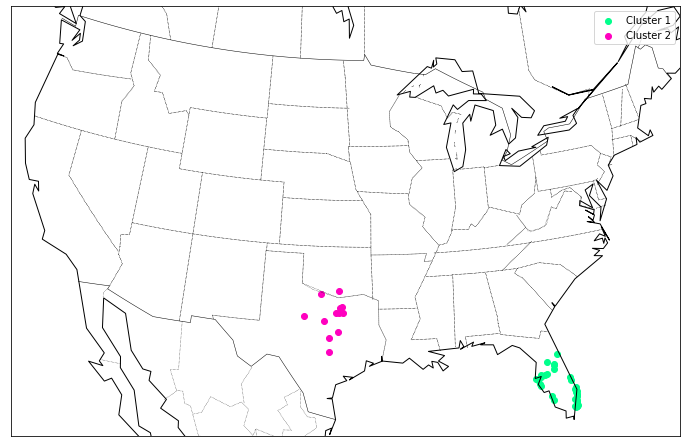

In [28]:
coordinates = usa_final_df[["latitude", "longitude"]].values

us_zika_model = DBSCAN(min_samples=3, eps=100, metric=great_circle_distance)
cluster_ids = us_zika_model.fit_predict(coordinates)

usa_final_df["cluster"] = cluster_ids

coordinates_list, colors = [], []

cluster_ids = np.unique(usa_final_df["cluster"].values)
color_ids = np.linspace(0, 1, len(cluster_ids))
cmap = mpl.cm.get_cmap("gist_rainbow")

for i in range(len(cluster_ids)):
    if cluster_ids[i] == -1:
        continue
    coordinates_list.append(
        usa_final_df[usa_final_df["cluster"]==cluster_ids[i]][["latitude", "longitude"]].values)
    colors.append(cmap(color_ids[i]))
    
scatterplot_us(map_plotter, coordinates_list, colors)

## World

In [29]:
headlines_df = pd.read_csv(os.path.join(DATA_DIR, "headlines-with-latlon.csv"))
headlines_df.head()

,headline,city,countrycode,latitude,longitude
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667


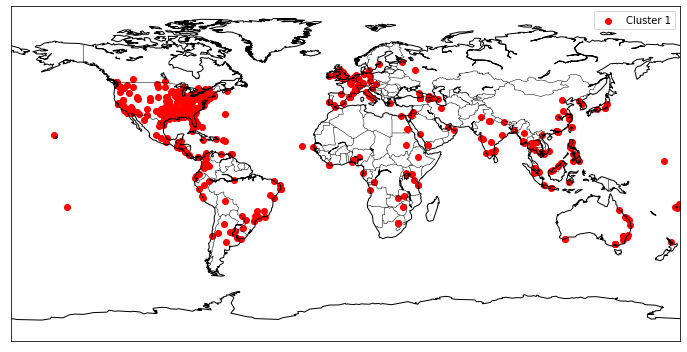

In [30]:
def scatterplot_world(map_plotter, coordinates_list, colors):
    assert(len(coordinates_list) == len(colors))
    fig = plt.figure(figsize=(12, 8))
    for cid, (coordinates, color) in enumerate(zip(coordinates_list, colors)):
        latitudes, longitudes = coordinates[:, 0], coordinates[:, 1]
        map_plotter.scatter(longitudes, latitudes, latlon=True, color=color, 
                            label="Cluster {:d}".format(cid + 1))
    map_plotter.drawcoastlines()
    map_plotter.drawcountries()
    plt.legend(loc="best")
    _ = plt.show()
    
coordinates = headlines_df[["latitude", "longitude"]].values
scatterplot_world(map_plotter, [coordinates], ["r"])

In [31]:
world_model = DBSCAN(min_samples=3, eps=250, metric=great_circle_distance)
cluster_ids = world_model.fit_predict(coordinates)

In [32]:
cids, ccounts = np.unique(cluster_ids, return_counts=True)
for cid, ccount in zip(cids, ccounts):
    print(cid, ccount)

-1 81
0 256
1 4
2 16
3 52
4 12
5 12
6 7
7 6
8 9
9 10
10 4
11 4
12 8
13 3
14 4
15 3
16 3
17 4
18 5
19 3
20 3
21 14
22 33
23 4
24 3
25 3
26 11
27 3
28 4
29 4
30 3
31 3
32 3
33 3


In [33]:
len(coordinates), len(headlines_df), len(cluster_ids)

(600, 600, 600)

In [34]:
headlines_df["cluster"] = cluster_ids
headlines_df.head()

,headline,city,countrycode,latitude,longitude,cluster
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,0
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597,0
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,0
3,"Mystery Virus Spreads in Recife, Brazil",Recife,BR,-8.05389,-34.88111,1
4,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667,0


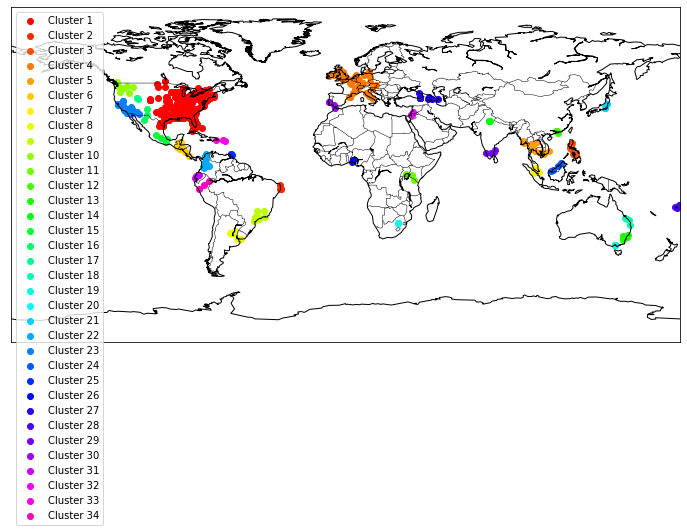

In [35]:
coordinates_list, colors = [], []

cluster_ids = np.unique(headlines_df["cluster"].values)
color_ids = np.linspace(0, 1, len(cluster_ids))
cmap = mpl.cm.get_cmap("gist_rainbow")

for i in range(len(cluster_ids)):
    if cluster_ids[i] == -1:
        continue
    coordinates_list.append(
        headlines_df[headlines_df["cluster"]==cluster_ids[i]][["latitude", "longitude"]].values)
    colors.append(cmap(color_ids[i]))
    
scatterplot_world(map_plotter, coordinates_list, colors)

### Clusters sorted by number of headlines

In [36]:
world_cluster_df = (headlines_df[headlines_df["cluster"] != -1]
                    .groupby("cluster")["headline"]
                    .count()
                    .reset_index(name="count")
                    .sort_values(["count"], ascending=False))
world_cluster_df.head(len(coordinates_list))

,cluster,count
0,0,256
3,3,52
22,22,33
2,2,16
21,21,14
5,5,12
4,4,12
26,26,11
9,9,10
8,8,9


### Headlines sorted by proximity to cluster centroid

As with the US case, we will look at the headlines for the top 5 clusters. 

__CONCLUSION__: Zika appears to be the dominant disease in the world headlines as well.

In [37]:
world_cluster_df = (headlines_df[headlines_df["cluster"] != -1]
                    .groupby("cluster")["headline", "latitude", "longitude"]
                    .apply(compute_cluster_properties)
                    .sort_values(["num_headlines"], ascending=False)
                    .reset_index("cluster"))
world_cluster_df.head()

,cluster,num_headlines,centroid_lat,centroid_lon
0,0,256.0,36.237874,-84.351076
1,3,52.0,49.891516,3.342509
2,22,33.0,34.850277,-117.881285
3,2,16.0,14.007481,121.456227
4,21,14.0,6.005380,-75.059064


In [38]:
world_headlines_scored_df = headlines_df.merge(world_cluster_df, on="cluster")
world_headlines_scored_df["dist_from_centroid"] = world_headlines_scored_df.apply(
    lambda row: great_circle_distance([row["latitude"], row["longitude"]], 
                                      [row["centroid_lat"], row["centroid_lon"]]), axis=1)

world_headlines_scored_df.head()

,headline,city,countrycode,latitude,longitude,cluster,num_headlines,centroid_lat,centroid_lon,dist_from_centroid
0,Zika Outbreak Hits Miami,Miami,US,25.77427,-80.19366,0,256.0,36.237874,-84.351076,762.971600
1,Could Zika Reach New York City?,New York City,US,40.71427,-74.00597,0,256.0,36.237874,-84.351076,638.299951
2,First Case of Zika in Miami Beach,Miami Beach,US,25.79065,-80.13005,0,256.0,36.237874,-84.351076,763.110991
3,Dallas man comes down with case of Zika,Dallas,US,32.78306,-96.80667,0,256.0,36.237874,-84.351076,747.056396
4,Zika Concerns are Spreading in Houston,Houston,US,29.76328,-95.36327,0,256.0,36.237874,-84.351076,777.890895


In [39]:
show_headlines(world_headlines_scored_df, 0).head(10)

130                              Spike of Rhinovirus Cases in Sevierville
228    Rumors about Hepatitis E Spreading in Morristown have been Refuted
17                                       Zika virus reported in Cleveland
231               Schools in Danville Closed Due to Tuberculosis Outbreak
22                               Nashville takes precautions against Zika
215          More Patients in Canton are Getting Diagnosed with Norovirus
144                                West Nile Virus Exposure in Alpharetta
221      Duluth Patient in Critical Condition after Contracting Rotavirus
120                                          Chickenpox Hits Simpsonville
210                                 Lawrenceville is infested with Dengue
Name: headline, dtype: object

In [40]:
show_headlines(world_headlines_scored_df, 3).head(10)

314                               Mad Cow Disease Disastrous to Brussels
278                              Scientists in Paris to look for answers
292    More Livestock in Fontainebleau are infected with Mad Cow Disease
294                                   Mad Cow Disease Spreads to Margate
298                                       Mad Cow Disease Hits Rotterdam
300                                  Herpes Keeps Spreading in Rochester
280                 Rochester authorities confirmed the spread of Dengue
316                    Contaminated Meat Brings Trouble for Bonn Farmers
315                           Case of Mad Cow Disease Reported in Hilden
310                             Duisburg up in Arms over Mad Cow Disease
Name: headline, dtype: object

In [41]:
show_headlines(world_headlines_scored_df, 22).head(10)

481    Barstow Patient in Critical Condition after Contracting Herpes
458           The Spread of Chikungunya in Arcadia has been Confirmed
471                                    Pneumonia Exposure in Alhambra
457                                     Zika Virus Arrives in Ontario
468        How to Avoid Respiratory Syncytial Virus in San Bernardino
473                         How to Avoid Tuberculosis in Santa Monica
482                      New medicine wipes out Influenza in Redlands
478                      Norovirus Vaccine is now Required in Anaheim
466                                       Rhinovirus Hits Bakersfield
452                 New medicine wipes out West Nile Virus in Ventura
Name: headline, dtype: object

In [42]:
show_headlines(world_headlines_scored_df, 2).head(10)

267                 Zika afflicts patient in Calamba
268    Batangas Tourism Takes a Hit as Virus Spreads
275            More Zika patients reported in Indang
266                    Spreading Zika reaches Bacoor
270                   Outbreak of Zika in Pasig City
265            Antipolo under threat from Zika Virus
263            Mandaluyong City under Siege by Virus
272         More Zika patients reported in Calumpang
264              More Quezon City Zika Transmissions
260               Zika alert - Manila now threatened
Name: headline, dtype: object

In [43]:
show_headlines(world_headlines_scored_df, 21).head(10)

433                                    Zika symptoms spotted in Bello
432                          New medicine wipes out Measles in Fresno
436                                   Spanish flu spreading in Madrid
437                                                Rabies Hits Madrid
439                              Spanish Flu Spreading through Madrid
440                              Spanish Flu Spreading through Madrid
444                      New medicine wipes out Meningitis in Sevilla
443                                          Zika spreads to Caucasia
431                                   Villavicencio under Zika threat
441    Rumors about Hepatitis C spreading in Darien have been refuted
Name: headline, dtype: object

In [44]:
headlines = world_headlines_scored_df["headline"].values
compute_disease_counts(headlines).most_common()

[('Zika', 37),
 ('Keeps', 12),
 ('Hepatitis', 8),
 ('Dengue', 6),
 ('Rotavirus', 5),
 ('Chlamydia', 4),
 ('HIV', 4),
 ('Bronchitis', 3),
 ('Mumps', 3),
 ('Norovirus', 3),
 ('Rhinovirus', 3),
 ('Chickenpox', 3),
 ('Varicella', 3),
 ('Mad', 3),
 ('Influenza', 2),
 ('Tuberculosis', 2),
 ('Pneumonia', 2),
 ('West', 2),
 ('Gonorrhea', 2),
 ('Respiratory', 2),
 ('Rabies', 2),
 ('Chikungunya', 2),
 ('are', 1),
 ('Flu', 1),
 ('Hollywood', 1),
 ('Syphilis', 1),
 ('Outbreak', 1),
 ('Meningitis', 1),
 ('Measles', 1),
 ('Ebola', 1),
 ('flu', 1),
 ('Swine', 1),
 ('Herpes', 1),
 ('Virus', 1)]

### World final report: Zika only

We filter down to Zika related headlines only, then recluster using DBSCAN and render the clusters on the world map.

Most of the zika clusters are around central America (including southern US and northern countries of South America), South East Asia, and North India. Smaller clusters are also visible in Western Asia.

In [45]:
world_final_df = headlines_df[headlines_df["headline"].apply(zika_only)]
len(headlines_df), len(world_final_df)

(600, 200)

/Users/palsujit/anaconda3/envs/disease/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


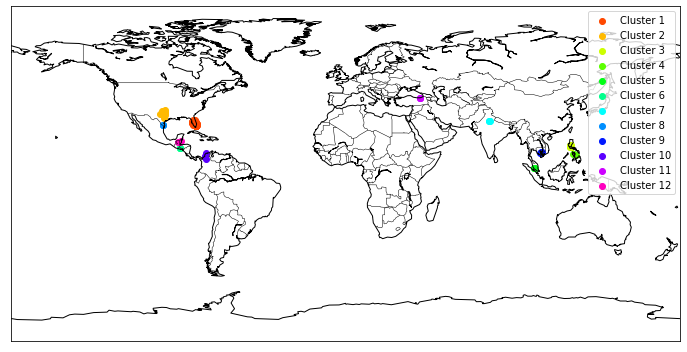

In [46]:
coordinates = world_final_df[["latitude", "longitude"]].values

world_zika_model = DBSCAN(min_samples=3, eps=100, metric=great_circle_distance)
cluster_ids = world_zika_model.fit_predict(coordinates)

world_final_df["cluster"] = cluster_ids

coordinates_list, colors = [], []

cluster_ids = np.unique(world_final_df["cluster"].values)
color_ids = np.linspace(0, 1, len(cluster_ids))
cmap = mpl.cm.get_cmap("gist_rainbow")

for i in range(len(cluster_ids)):
    if cluster_ids[i] == -1:
        continue
    coordinates_list.append(
        world_final_df[world_final_df["cluster"]==cluster_ids[i]][["latitude", "longitude"]].values)
    colors.append(cmap(color_ids[i]))
    
scatterplot_world(map_plotter, coordinates_list, colors)